# Deep Learning Regression Notebook
This notebook is written for defining and compiling a neural network using Keras' Sequential API. Model is defined by function `create_model` with signature:
* `activ_fun` – The activation function used in the hidden layers (here ReLU is applied).
* `units` – The number of neurons in the first hidden layer. Further layers are reduced in number.
* `input_shape` – The shape of the input data.


The model is designed for **regression tasks** and incorporates **regularization** and **dropout** to prevent overfitting.

## Model Architecture
Model is built with hidden layers with first input layer. All layers are regularized to prevent overfitting, and after each layer the droput technique is applied to reduce overfitting as well.
### 1. First Hidden Layer
* A fully connected (Dense) layer with units neurons.
* L2 regularization (L2(1e-3)) helps prevent overfitting.
* Uses the activation function specified by activ_fun.
* Defines input_shape (only needed for the first layer).

### 2. Droput
* Randomly drops 50% of neruons in the first layer and further 25% of neurons in hidden layers to reduce overfitting.

### 3. Output layer
* Output layer is build of a single neuron with a linear activation function. This is appropriate for regression problems, where the goal is to predict continuous values.

## Model compilation
Model is compiled with use of:
* Optimizer: `adam` (Adaptive Moment Estimation) – a widely used optimizer in deep learning.
* Loss Function: `mse` (Mean Squared Error), suitable for regression tasks.



In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import regularizers
from keras import models
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

/Users/pciuh/Library/Mobile Documents/com~apple~CloudDocs/Wrk/DatAna/add_res/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def input_scaler(X):
    x_avg = X.mean()
    x_std = X.std()
    Xn = X - x_avg
    Xn /= x_std
    return (Xn,x_avg,x_std)

In [4]:
def create_model(activ_fun,units,input_shape):
    model = models.Sequential([
    #layers.BatchNormalization(),
    layers.Dense(units//1,kernel_regularizer=regularizers.L2(1e-3), activation=activ_fun, input_shape=input_shape),
    layers.Dropout(0.50),
    layers.Dense(units//2,kernel_regularizer=regularizers.L2(1e-3), activation=activ_fun),
    layers.Dropout(0.25),
    layers.Dense(1,activation='linear')
    ])
    model.compile(optimizer='adam',loss='mse')
    return model

In [5]:
BaseDir = os.getcwd()
InputDir = os.path.join(BaseDir,'input')

FileName = 'kaw_all.ftr'
ModelFileName = FileName[:-4]+'-model.h5'

In [6]:
EPOCHS     = 250
BATCH_SIZE = 48
RANDOM     = 20250125
RANDOM     = 20250126

In [7]:
df = pd.read_feather(os.path.join(InputDir,FileName))

df['LEL'] = df['LE']/df['L']
df['LRL'] = df['LR']/df['L']
df['LB']  = df['L']/df['B']
df['BT']  = df['B']/df['Tm']

X = df.drop(['L','B','Tm','Ta','Tf','LE','LR','kyy'],axis=1).copy()
y = X.pop('kaw')

display(X.describe())
display(y.describe())

,CB,Fr,WaveDir,ldl,LEL,LRL,LB,BT
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000
mean,0.731312,0.165182,130.987903,0.908645,0.269132,0.198798,6.231346,3.865784
std,0.099299,0.050917,58.158899,0.550462,0.083499,0.067202,0.720862,1.411495
min,0.512784,0.085890,0.000000,0.150000,0.121862,0.061071,4.039475,2.105467
25%,0.642044,0.124304,90.000000,0.492117,0.200348,0.165237,5.617726,2.762417
50%,0.755578,0.159567,150.000000,0.800000,0.242746,0.207214,6.161419,3.501610
75%,0.820188,0.196646,180.000000,1.200000,0.337833,0.235268,6.800663,4.509172
max,0.894305,0.310231,180.000000,3.157025,0.650237,0.391973,8.362595,8.470690


count    1240.000000
mean        0.704501
std         0.599195
min        -0.570690
25%         0.180500
50%         0.625000
75%         1.053296
max         2.759770
Name: kaw, dtype: float64

In [8]:
Xn,x_avg,x_std = input_scaler(X)

x_scale = pd.concat([x_avg,x_std],axis=1)
x_scale.columns = ['avg','std']
x_scale.to_csv(os.path.join(InputDir,FileName[:-4]+'-scale.csv'),sep=';')

X_train = Xn.sample(frac=.666,random_state=RANDOM)
X_valid = Xn.drop(X_train.index)

y_train = y[X_train.index]
y_valid = y[X_valid.index]

X_train,y_train = shuffle(X_train,random_state=RANDOM),shuffle(y_train,random_state=RANDOM)
X_valid,y_valid = shuffle(X_valid,random_state=RANDOM),shuffle(y_valid,random_state=RANDOM)

display(X_train.shape)
display(X_valid.shape)

input_shape = [X_train.shape[1]]
display("Input shape: {}".format(input_shape))

(826, 8)

(414, 8)

'Input shape: [8]'

In [9]:
model = create_model('relu',320,input_shape)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=False,
)
print('\n\nModel Summary:\n')
model.summary()



Model Summary:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               2880      
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               51360     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 54401 (212.50 KB)
Trainable params: 54401 (212.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,loss,val_loss
247,0.072807,0.086195
248,0.068304,0.083791
249,0.070816,0.088802


13/13 [==============================] - 0s 469us/step


'Minimum Validation Loss: 0.0819'

'R2:'

0.786536679694601

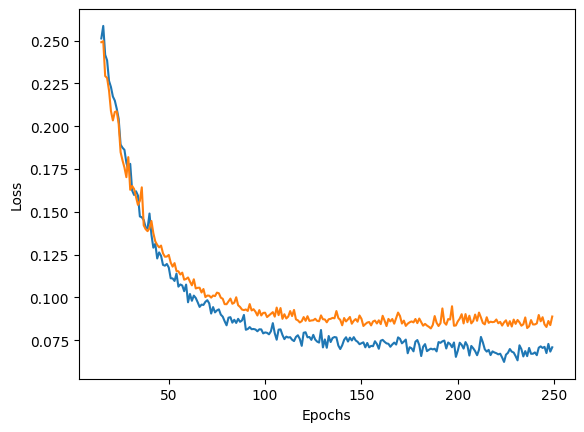

In [13]:
hdf = pd.DataFrame(history.history)

display(hdf.tail(3))
fig,ax = plt.subplots()
ax.plot(hdf.loc[15:, ['loss', 'val_loss']])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

y_pred = model.predict(X_valid)

display('Minimum Validation Loss: {:0.4f}'.format(hdf['val_loss'].min()))
display('R2:',r2_score(y_pred,y_valid))

In [ ]:
fig,ax = plt.subplots()
ax.scatter(y_valid,y_pred)
ax.plot([min(y_valid),max(y_valid)],[min(y_valid),max(y_valid)],'--r')
ax.set_aspect(1)

Text(0.5, 0, 'Residues')

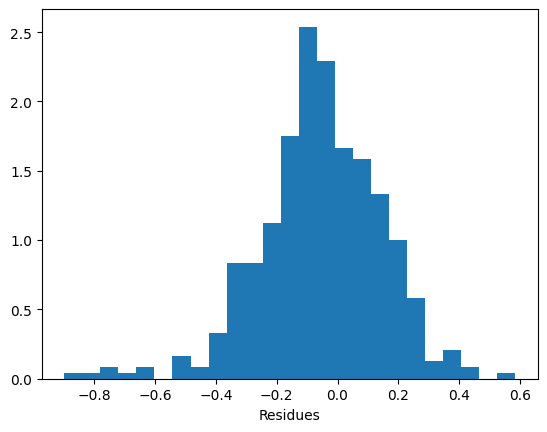

In [19]:
res = y_valid-y_pred[:,0]
bins = np.histogram_bin_edges(res, bins='scott')

fig,ax = plt.subplots()
ax.hist(res,bins=bins,density=True)
ax.set_xlabel('Residues')